# DTSA 5510 Unsupervised Learning - Clustering Mushrooms to Predict Edibility

Spring 2024

Anna Sanders

Mushrooms are a part of funguses that typically grow above ground. Many mushrooms are edible, but some are extremely toxic to humans. Edible mushrooms are very nutritious. Mushrooms can also be used for medicinal purposes. Many varieties of mushrooms are grown for consumption, but some are foreged, but must be closely inspected in order to ensure they are edible. As mushrooms come in various shapes and sizes, it is important to not eat a wild mushroom unless absolutley certain it is not poisonous. 

While a machine learning model is unlikely to be 100% reliable in classifying poisonous and non-poisonous mushrooms, there may still be value in being able to cluster similar types of mushrooms.

The data was taken from [this dataset](https://www.kaggle.com/datasets/uciml/mushroom-classification), and contains categorical features of various mushroom properties.

***Resources:***
* https://en.wikipedia.org/wiki/Mushroom

***Data Citation:***
```
UCI Machine Learning. (2016, December 1). Mushroom classification. Mushroom Classification. https://www.kaggle.com/datasets/uciml/mushroom-classification 
```

## Import Libraries

In [2]:
# Libraries
import pandas as pd
import numpy as np

## Dates and Times
import pytz
from dateutil import parser
from datetime import timezone,datetime,timedelta
from dateutil.relativedelta import relativedelta
from datetime import date 

## String manipulation
import string
import re #regex
import json #json parsing
## Data Generation
import random

# Data Manipulation
import pandas as pd
import numpy as np
## Vector Math
from numpy.linalg import norm
## Math
import math

# Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# Time
import time

# Sklearn Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, Birch

# Metrics
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Loading and Cleaning Data

This data is particularly interesting because all features are categorical, including poisonous/safe column, which is the target of prediction.

Only column 11, which is 'stalk-root' has missing values. We can use a impute a seperate category ('m') for these missing values.

Overall, there are 8,124 mushrooms in this dataset.

In [3]:
mushrooms = pd.read_csv('mushroom/mushroom_csv.csv')
mushrooms_class = mushrooms['class'] #edibility class
mushrooms = mushrooms.drop(columns = {'class'})
mushrooms['stalk-root'] = mushrooms['stalk-root'].fillna('m') #Fill NANs with 'm' for missing

In [4]:
len(mushrooms)

8124

Below is the printed list of categorical features in this dataset, along with each column's category list. We can see that there can be a large number of categories within each feature. 

In [3]:
print('Columns: ', len(mushrooms.columns))
print(list(mushrooms.columns))

Columns:  22
['cap-shape', 'cap-surface', 'cap-color', 'bruises%3F', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


In [4]:
for i in mushrooms.columns:
    print(i, ": ", np.unique(mushrooms[i]))

cap-shape :  ['b' 'c' 'f' 'k' 's' 'x']
cap-surface :  ['f' 'g' 's' 'y']
cap-color :  ['b' 'c' 'e' 'g' 'n' 'p' 'r' 'u' 'w' 'y']
bruises%3F :  ['f' 't']
odor :  ['a' 'c' 'f' 'l' 'm' 'n' 'p' 's' 'y']
gill-attachment :  ['a' 'f']
gill-spacing :  ['c' 'w']
gill-size :  ['b' 'n']
gill-color :  ['b' 'e' 'g' 'h' 'k' 'n' 'o' 'p' 'r' 'u' 'w' 'y']
stalk-shape :  ['e' 't']
stalk-root :  ['b' 'c' 'e' 'm' 'r']
stalk-surface-above-ring :  ['f' 'k' 's' 'y']
stalk-surface-below-ring :  ['f' 'k' 's' 'y']
stalk-color-above-ring :  ['b' 'c' 'e' 'g' 'n' 'o' 'p' 'w' 'y']
stalk-color-below-ring :  ['b' 'c' 'e' 'g' 'n' 'o' 'p' 'w' 'y']
veil-type :  ['p']
veil-color :  ['n' 'o' 'w' 'y']
ring-number :  ['n' 'o' 't']
ring-type :  ['e' 'f' 'l' 'n' 'p']
spore-print-color :  ['b' 'h' 'k' 'n' 'o' 'r' 'u' 'w' 'y']
population :  ['a' 'c' 'n' 's' 'v' 'y']
habitat :  ['d' 'g' 'l' 'm' 'p' 'u' 'w']


## Data Exploration

Text(0.5, 1.0, 'Habitat Distribution')

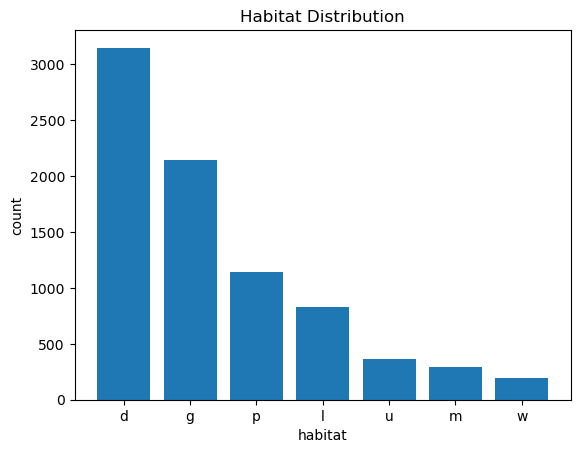

In [5]:
fig, ax = plt.subplots()
ax.bar(mushrooms['habitat'].value_counts().index, mushrooms['habitat'].value_counts().values)
ax.set_xlabel('habitat')
ax.set_ylabel('count')
ax.set_title('Habitat Distribution')

Text(0.5, 1.0, 'Cap Color Distribution')

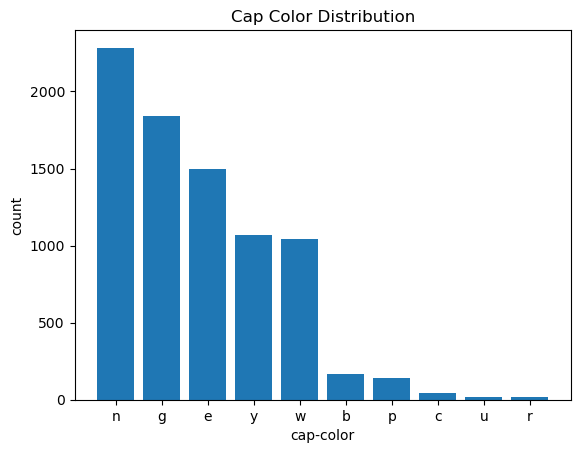

In [6]:
fig, ax = plt.subplots()
ax.bar(mushrooms['cap-color'].value_counts().index, mushrooms['cap-color'].value_counts().values)
ax.set_xlabel('cap-color')
ax.set_ylabel('count')
ax.set_title('Cap Color Distribution')

Text(0.5, 1.0, 'Odor Distribution')

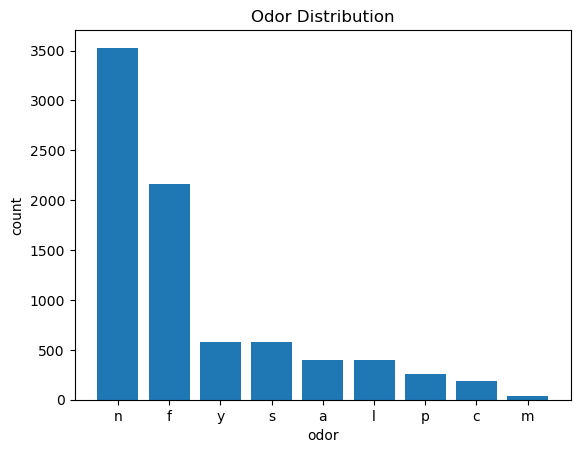

In [7]:
fig, ax = plt.subplots()
ax.bar(mushrooms['odor'].value_counts().index, mushrooms['odor'].value_counts().values)
ax.set_xlabel('odor')
ax.set_ylabel('count')
ax.set_title('Odor Distribution')

Looking at a select few dimension's distributions, it appears that certain categories in each dimension are more frequent than others. We will need to make sure that the train test split will split the data to ensure full coverage of all of the dimensional categories.

In [8]:
corr_matrix = pd.get_dummies(mushrooms).corr()
corr_threshold = 0.5
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        if i == j:
            continue
        elif corr_matrix.iloc[i,j] > corr_threshold:
            print(corr_matrix.columns[i], 'and', corr_matrix.columns[j], 'correlation: %.3f' %(corr_matrix.iloc[i,j]))
            

cap-color_r and ring-type_f correlation: 0.576
cap-color_u and ring-type_f correlation: 0.576
bruises%3F_f and stalk-surface-above-ring_k correlation: 0.541
bruises%3F_f and stalk-surface-below-ring_k correlation: 0.531
bruises%3F_f and ring-type_e correlation: 0.506
bruises%3F_t and stalk-surface-above-ring_s correlation: 0.562
bruises%3F_t and stalk-surface-below-ring_s correlation: 0.506
bruises%3F_t and ring-type_p correlation: 0.767
odor_a and stalk-root_c correlation: 0.515
odor_f and stalk-surface-above-ring_k correlation: 0.584
odor_f and stalk-surface-below-ring_k correlation: 0.600
odor_f and ring-type_l correlation: 0.724
odor_f and spore-print-color_h correlation: 0.800
odor_l and stalk-root_c correlation: 0.515
odor_m and stalk-color-above-ring_c correlation: 1.000
odor_m and stalk-color-below-ring_c correlation: 1.000
odor_m and ring-number_n correlation: 1.000
odor_m and ring-type_n correlation: 1.000
odor_s and gill-color_b correlation: 0.531
odor_y and gill-color_b cor

Looking at the correlations between dimensions, some do look to be highly correlated, but this is potentially due uneven distribution of mushrooms within each dimension, which would create potentially only one, or a few, mushroom sample with the combination of features.

## Train Test Split

The train test split will be on a 20% of the entire data, chosen randomly. Not all models will use the train-test split, but it is imporant to do, especially since there will be further comparisons between supervised models.

In [9]:
train_x, test_x, train_y, test_y = train_test_split(mushrooms, mushrooms_class, \
                                                    test_size=0.2, random_state=1)

In [10]:
print('Train Length:', len(train_x))
print('Test Length:', len(test_x))

Train Length: 6499
Test Length: 1625


## Build Pipeline

We will build a simple pipeline with a OneHotEncoder transformer for all columns of the data.

In [11]:
# Data Preprocessing
categorical_features = list(mushrooms.columns)
categorical_transformers = Pipeline(
    steps=[('encoder', OneHotEncoder())]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', categorical_transformers, categorical_features)
    ]
)

pipeline = Pipeline(
    steps=[('preprocessor', preprocessor)]
)

In [12]:
train_x_m = pipeline.fit_transform(train_x)
test_x_m = pipeline.transform(test_x)
mushrooms_m = pipeline.fit_transform(mushrooms)

## Clustering

We can use a variety of clusters from the sklearn module to create two clusters. Unfortunatly, this data is fairly sparse, so Non-Negative Matrix Factorization will not be used.

We will first create a function to test the two combinations of cluster labels and actual labels. The function will return the best label combo, the highest accuracy score, and the re-labeled model labels.

In [13]:
def best_labs(train_y, model_labels):
    max_acc = float('-inf')
    max_cats = None
    y_cats = list(np.unique(train_y))
    best_temp = None
    for i in [y_cats, sorted(y_cats, reverse=True)]:
        temp = model_labels.copy()
        temp = [i[0] if itm == 0 else i[1] for itm in temp]
        acc = accuracy_score(train_y, temp)
        if acc > max_acc:
            max_cats = i
            max_acc = acc
            best_temp = temp
    return max_cats, max_acc, temp

In [37]:
start = time.time()
kmeans_model = KMeans(n_clusters=2, n_init='auto', random_state=10) #Random State 10 leads to good results
kmeans_model.fit(train_x_m)
kmeans_train_labels = kmeans_model.labels_
kmeans_labs, kmeans_acc, kmeans_train_labels2 = best_labs(train_y, kmeans_train_labels)
print('K-Means Train Accuracy: %.3f' %(kmeans_acc))
kmeans_test_labels = kmeans_model.predict(test_x_m)
kmeans_test_labels = [kmeans_labs[0] if itm == 0 else kmeans_labs[1] for itm in kmeans_test_labels]
print('K-Means Test Accuracy: %.3f' %(accuracy_score(test_y, kmeans_test_labels)))
end = time.time()
print('K-Means Time: %.2f' %(end - start))
print()

start = time.time()
agg_model = AgglomerativeClustering(n_clusters=2)
agg_model.fit(mushrooms_m.toarray())
agg_train_labels = agg_model.labels_
agg_labs, agg_acc, agg_train_labels2 = best_labs(mushrooms_class, agg_train_labels)
print('Agglomerative Clustering Accuracy: %.3f' %(agg_acc))
end = time.time()
print('Agglomerative Time: %.2f' %(end - start))
print()

start = time.time()
birch_model = Birch(n_clusters=2)
birch_model.fit(train_x_m)
birch_train_labels = birch_model.labels_
birch_labs, birch_acc, birch_train_labels2 = best_labs(train_y, birch_train_labels)
print('Birch Train Accuracy: %.3f' %(birch_acc))
birch_test_labels = birch_model.predict(test_x_m)
birch_test_labels = [birch_labs[0] if itm == 0 else birch_labs[1] for itm in birch_test_labels]
print('Birch Test Accuracy: %.3f' %(accuracy_score(test_y, birch_test_labels)))
print('Birch Combined Accuracy: %.3f' %(birch_acc*0.8 + accuracy_score(test_y, birch_test_labels)*0.2))
end = time.time()
print('Birch Time: %.2f' %(end - start))

K-Means Train Accuracy: 0.892
K-Means Test Accuracy: 0.890
K-Means Time: 0.21

Agglomerative Clustering Accuracy: 0.890
Agglomerative Time: 3.60

Birch Train Accuracy: 0.892
Birch Test Accuracy: 0.885
Birch Combined Accuracy: 0.890
Birch Time: 3.27


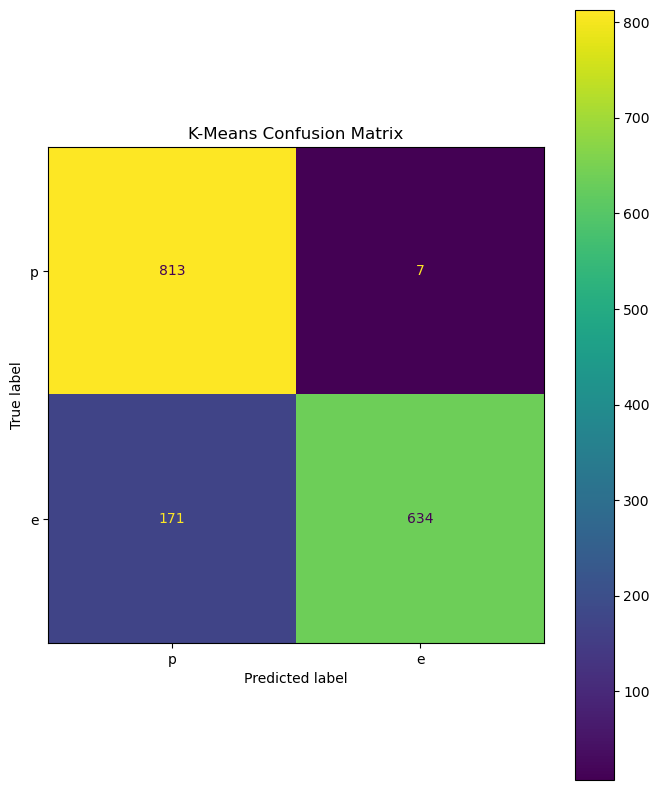

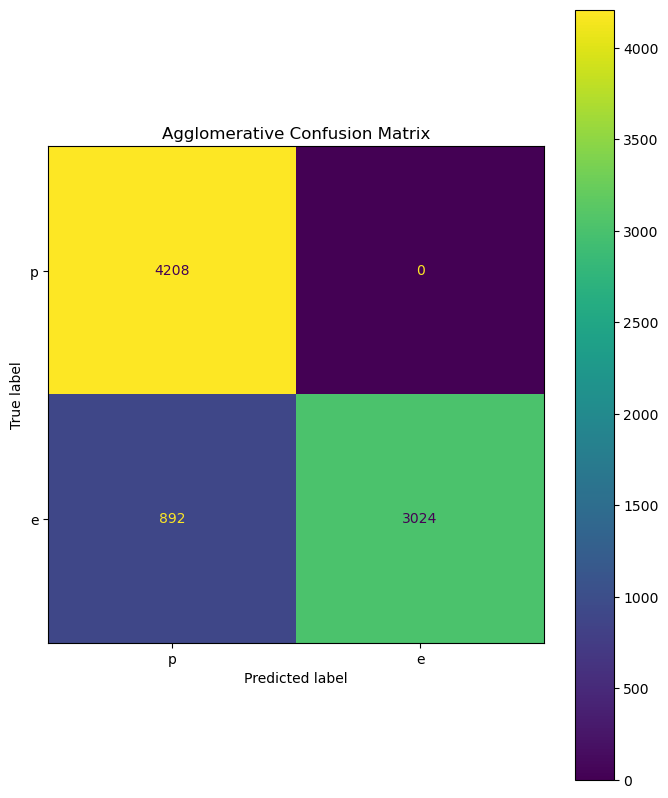

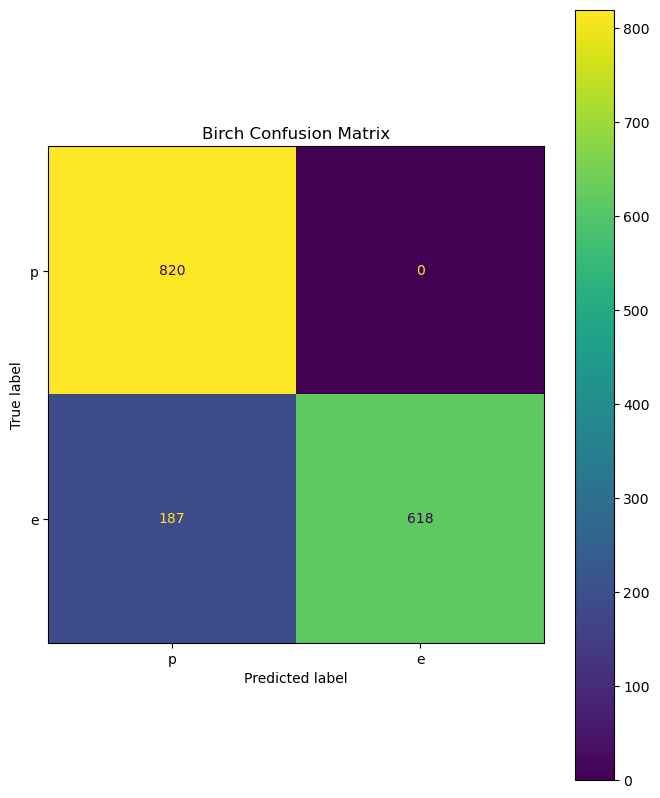

In [36]:
cm = confusion_matrix(test_y, kmeans_test_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels = kmeans_labs)
fig, ax = plt.subplots(figsize=(8,10))
ax.set_title('K-Means Confusion Matrix')
cmd.plot(ax=ax)

cm = confusion_matrix(mushrooms_class, agg_train_labels2)
cmd = ConfusionMatrixDisplay(cm, display_labels = agg_labs)
fig, ax = plt.subplots(figsize=(8,10))
ax.set_title('Agglomerative Confusion Matrix')
cmd.plot(ax=ax)

cm = confusion_matrix(test_y, birch_test_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels = birch_labs)
fig, ax = plt.subplots(figsize=(8,10))
ax.set_title('Birch Confusion Matrix')
cmd.plot(ax=ax)

The confusion matrices for each clustering algorithm leads to some interesting results. Both true positives and true negatives are important results, but false negatives, or the case where the true label was 'p' for poisonous but the model classified it as 'e' for edible, is much worse than the false postive case (edible mushrooms classified as poisonous). The K-Means algorithm classified 7 poisonous mushrooms as edible, but both the Agglomerative and Birch clustering has zero cases. 

From this, we can calculate an additional metric: the False Negative Rate. For the Agglomerative and Birch clustering, the false negative rate would be 0. For the K-Menas clustering, the false negative rate is $7/(813+7)=7/820=0.0085$, which is very low, but could potentially result in someone becoming very sick or even killed.

We can also look at the time taken for the model to cluster as a metric. Both the Agglomerative and Birch clustering took just over 3 seconds, while the K-Means clustering only took 1/5th of a second.

## Comparison to Supervised Classification

We can quickly train various classification algorithms and compare accuracy and model fit time.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [42]:
start = time.time()
log_model = LogisticRegression()
log_model.fit(train_x_m, train_y)
log_predict = log_model.predict(test_x_m)
print('Logistic Regression Accuracy: %.3f' %(accuracy_score(test_y, log_predict)))
end = time.time()
print('Logistic Regression Time: %.2f' %(end - start))

start = time.time()
svc_model = SVC()
svc_model.fit(train_x_m, train_y)
svc_predict = svc_model.predict(test_x_m)
print('SVC Accuracy: %.3f' %(accuracy_score(test_y, svc_predict)))
end = time.time()
print('SVC Time: %.2f' %(end - start))

start = time.time()
rf_model = RandomForestClassifier()
rf_model.fit(train_x_m, train_y)
rf_predict = rf_model.predict(test_x_m)
print('Random Forest Accuracy: %.3f' %(accuracy_score(test_y, rf_predict)))
end = time.time()
print('Random Forest Time: %.2f' %(end - start))

Logistic Regression Accuracy: 0.998
Logistic Regression Time: 0.06
SVC Accuracy: 1.000
SVC Time: 0.74
Random Forest Accuracy: 1.000
Random Forest Time: 0.44


As we can see from the results, supervised classification algorithms classify the mushrooms at a higher accuraccy and have much lower modeling times overall.

# Conclusion

The key takeway from this project is that if a supervised model can be created, it will likely perform better, both in terms of accuracy and compute time, than an unsupervised model. Interestingly though, with unsupervised models, while not as accurate as the supervised models, the unsupervised models predicted more false positives (edible mushrooms classified as poisonous) than false negatives (poisonous mushrooms classified as edible), which is the 'better' incorrect result. Additionally, the unsupervised cluster results are still interesting, as even without 'training' enough difference was found between edible and poisonous mushrooms to group them soley based on thier listed features.

Overall, this project was interesting to complete. Working with a dataset that was completely categorical was interesting to deal with. Future improvements could be made by potentially reducing the overall number of features, but was not necessary as the dataset was fairly small overall.